This is a notebook that explains how I create the landmask array, coastal cells array, border currents, and distance to shore array. Inspired by Victor's Beaching Kernel, Steffie's code review and some stuff that I did in my master's thesis. 
<div style="text-align: right"> Claudio Pierard </div>


> This notebook was used for developing the script `landmask.py` where everything is wrapped around functions with a brief documentation.

TOC:
1. [Import the velocity fields](#1.-Import-the-velocity-fields)
2. [Make the land mask](#2.-Make-the-land-mask)
3. [Detect the coast]( 3.-Detect-the-coast)
4. [Assigning coastal velocities](#4.-Assigning-coastal-velocities)
5. [Distance to shore](#5.-Distance-to-shore)
6. [Saving in a .nc file](#6.-Saving-in-a-.nc-file)
7. [Extra. Point Nemo](#Extra.-Point-Nemo)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
from netCDF4 import Dataset
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
%matplotlib inline

### 1. Import the velocity field

Import one of the velocity fields that you use for your simulation. I'm using CMEMS 1/12 degree.

In [2]:
file_path = "../data/mercatorpsy4v3r1_gl12_mean_20180101_R20180110.nc"
indices = {'lat': range(1, 960), 'lon': range(1284, 2460)}

In [3]:
model = xr.load_dataset(file_path)

In [4]:
lons = model['longitude'][indices['lon']]
lats = model['latitude'][indices['lat']]
X, Y = np.meshgrid(lons, lats)

### 2. Make the land mask

We make an array with the land mask where `land = 1` and `ocean = 0`.

In [5]:
def make_landmask(fielddata, indices):
    """Returns landmask where land = 1 and ocean = 0
    fielddata is a netcdf file.
    indices is a dictionary such as:
    indices = {'lat': slice(1, 900), 'lon': slice(1284, 2460)}.
    """
    datafile = Dataset(fielddata)

    landmask = datafile.variables['uo'][0, 0, indices['lat'], indices['lon']]
    landmask = np.ma.masked_invalid(landmask)
    landmask = landmask.mask.astype('int')

    return landmask

In [6]:
landmask = make_landmask(file_path, indices)

Text(0.5, 1.0, 'Landmask')

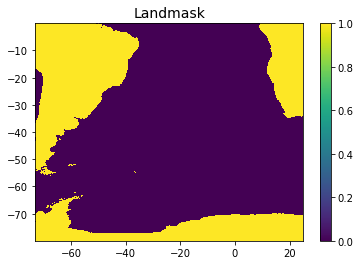

In [7]:
plt.figure()
plt.pcolormesh(X, Y, landmask, shading='auto')
plt.colorbar()
plt.title('Landmask', fontsize=14)

### 3. Detect the coast

By computing the Laplacian from `landmask`, such as

$$\nabla^2 \text{landmask} = \partial_{xx} \text{landmask} + \partial_{yy} \text{landmask},$$

and by filtering the positive and negative values, we can detect the coastal and the shore cells (the edges). The coastal cells are the ocean cells next to land and the shore cells are land cells next to the ocean.

In [8]:
# Computing the Laplace operator of landmask (in three lines)
mask_lap = np.roll(landmask, -1, axis=0) + np.roll(landmask, 1, axis=0)
mask_lap += np.roll(landmask, -1, axis=1) + np.roll(landmask, 1, axis=1)
mask_lap -= 4*landmask 

coastal = ma.masked_array(landmask, mask_lap>0)  # ocean cell next to land.
shore = ma.masked_array(landmask, mask_lap<0)  # land cell next to ocean.
coastal = coastal.mask.astype('int') #setting coastal cells equal to 1 and the rest to 0
shore = shore.mask.astype('int') # same but for the shore cells

To see what we did, we zoom somewhere in Argentina.

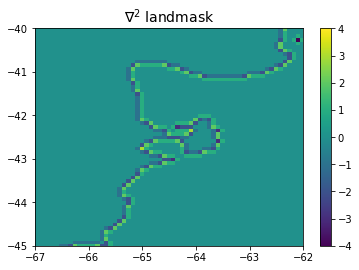

In [9]:
plt.figure()
plt.pcolormesh(X,Y, mask_lap, shading='auto')
plt.xlim(-67, -62)
plt.ylim(-45,-40)
plt.title(r'$\nabla^2$ landmask', fontsize=14)
plt.colorbar()

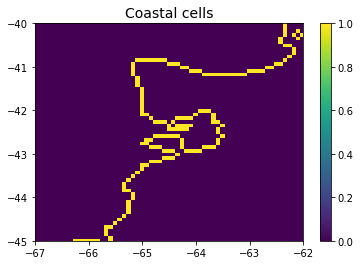

In [10]:
plt.figure()
plt.pcolormesh(X,Y, coastal, shading='auto')
plt.xlim(-67, -62)
plt.ylim(-45,-40)
plt.title('Coastal cells', fontsize=14)
plt.colorbar()

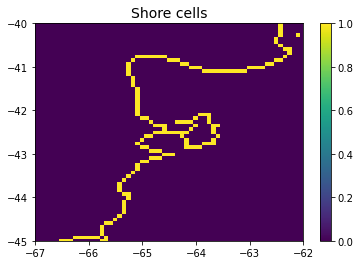

In [11]:
plt.figure()
plt.pcolormesh(X,Y, shore, shading='auto')
plt.xlim(-67, -62)
plt.ylim(-45,-40)
plt.title('Shore cells', fontsize=14)
plt.colorbar()

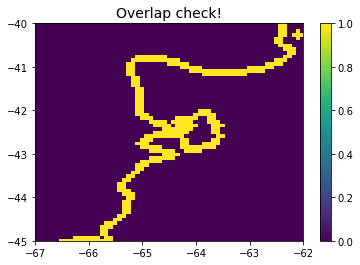

In [12]:
plt.figure()
plt.pcolormesh(X,Y, coastal + shore, shading='auto')
plt.xlim(-67, -62)
plt.ylim(-45,-40)
plt.title('Overlap check!', fontsize=14)
plt.colorbar()

> obs: the arrays don't ovelap!

By the way, that strange peninsula is the Valdes Peninsula in Argentina and this is how it looks: [click for surprise.](https://oceancolor.gsfc.nasa.gov/gallery/feature/images/LC08_L1TP_227089-090_20210408_20210408_01_RT.PeninsulaValdes.jpg)

You are welcome :)

In [13]:
# Wrapping the code around functions.
def get_coastal_cells(landmask):
    """Function that detects the coastal cells, i.e. the ocean cells directly
    next to land. Computes the Laplacian of landmask.

    - landmask: the land mask built using `make_landmask`, where land cell = 1
                and ocean cell = 0.

    Output: 2D array array containing the coastal cells, the coastal cells are
            equal to one, and the rest is zero.
    """
    mask_lap = np.roll(landmask, -1, axis=0) + np.roll(landmask, 1, axis=0)
    mask_lap += np.roll(landmask, -1, axis=1) + np.roll(landmask, 1, axis=1)
    mask_lap -= 4*landmask
    coastal = np.ma.masked_array(landmask, mask_lap > 0)
    coastal = coastal.mask.astype('int')

    return coastal

def get_shore_cells(landmask):
    """Function that detects the shore cells, i.e. the land cells directly
    next to the ocean. Computes the Laplacian of landmask.

    - landmask: the land mask built using `make_landmask`, where land cell = 1
                and ocean cell = 0.

    Output: 2D array array containing the shore cells, the shore cells are
            equal to one, and the rest is zero.
    """
    mask_lap = np.roll(landmask, -1, axis=0) + np.roll(landmask, 1, axis=0)
    mask_lap += np.roll(landmask, -1, axis=1) + np.roll(landmask, 1, axis=1)
    mask_lap -= 4*landmask
    shore = np.ma.masked_array(landmask, mask_lap < 0)
    shore = shore.mask.astype('int')

    return shore

### 4. Assigning coastal velocities

For the antibeaching kernel, we need a border velocity field that pushes the particles back to the ocean. This velocity field has to be parallel to the normal coast vector. For making this velocity field, we can take the simple derivative of `landmask` and project the result to the `coastal` array, this will capture the orientation of the velocity vectors. Then, to make this vectors unitary, we normalize it.

In [14]:
Ly = np.roll(landmask, -1, axis=0) - np.roll(landmask, 1, axis=0)
Lx = np.roll(landmask, -1, axis=1) - np.roll(landmask, 1, axis=1)

# In case you need a double cell border velocity use:
# v_x = -Lx*(coastal+shore) 
# v_y = -Ly*(coastal+shore)

# If you just need a single cell border velocity then use this one:
v_x = -Lx*(coastal) 
v_y = -Ly*(coastal) 


magnitude = np.sqrt(v_y**2 + v_x**2)
# the coastal cells between land create a problem (islands). The magnitude there is zero.
# I force it to be one to avoid problems when normalizing.
ny, nx = np.where(magnitude==0)
magnitude[ny,nx] = 1

v_x = v_x/magnitude
v_y = v_y/magnitude

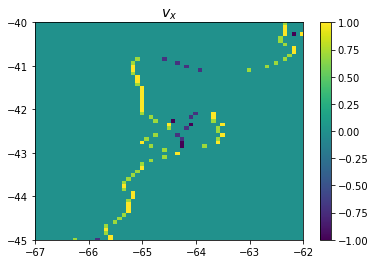

In [15]:
plt.figure()
plt.pcolormesh(X,Y, v_x, shading='auto')
plt.xlim(-67, -62)
plt.ylim(-45,-40)
plt.title(r'$v_x$', fontsize=14)
plt.colorbar()

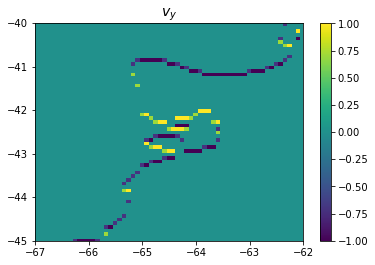

In [16]:
plt.figure()
plt.pcolormesh(X,Y, v_y, shading='auto')
plt.xlim(-67, -62)
plt.ylim(-45,-40)
plt.title(r'$v_y$', fontsize=14)
plt.colorbar()

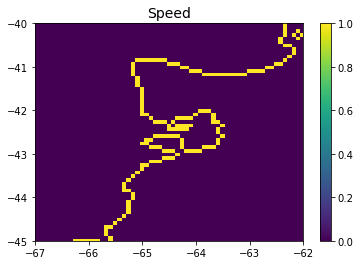

In [17]:
plt.figure()
plt.pcolormesh(X,Y, np.sqrt(v_x**2 + v_y**2), shading='auto')
plt.xlim(-67, -62)
plt.ylim(-45,-40)
plt.title('Speed', fontsize=14)
plt.colorbar()

In [18]:
# Wrapping everything around a function.
def create_border_current(landmask, double_cell=False):
    """Function that creates a border current 1 m/s pointing away from shore.

    - landmask: the land mask built using `make_landmask`.
    - double_cell: Boolean for determining if you want a double cell.
      Default set to False.

    Output 
    - v_x, v_y: two 2D arrays, one for each camponent of the velocity.
    """
    shore = get_shore_cells(landmask)
    coastal = get_coastal_cells(landmask)
    Ly = np.roll(landmask, -1, axis=0) - np.roll(landmask, 1, axis=0)
    Lx = np.roll(landmask, -1, axis=1) - np.roll(landmask, 1, axis=1)
    
    if double_cell:
        v_x = -Lx*(coastal+shore) 
        v_y = -Ly*(coastal+shore)
    else:
        v_x = -Lx*(coastal)
        v_y = -Ly*(coastal)

    magnitude = np.sqrt(v_y**2 + v_x**2)
    # the coastal cells between land create a problem. Magnitude there is zero
    # I force it to be 1 to avoid problems when normalizing.
    ny, nx = np.where(magnitude == 0)
    magnitude[ny, nx] = 1

    v_x = v_x/magnitude
    v_y = v_y/magnitude

    return v_x, v_y

### 5. Distance to shore
**Warning:** This method is not accurate for long distances.

The following algorithm counts how many cells there are from the shore. If you know the size of the cells you can get the distance to shore. This is quite difficult because the cell size changes according to the latitude.

The main idea is to use the `get_coastal_cells` function iteratively following this recipe:
1. Get `c1`, the coastal cells from `landmask`.
2. Add `c1` to `landmask`.
3. Get `c2` from `c1` + `landmask`.
4. Add `c2` to `c1` + `landmask`.
5. Get `c3` from `c1` + `c2` + `landmask`.
6. So on ...

Remember that the coastal cells have a value of $1$ and the non-coastal cells $0$. The `landmask` is $1$ where there is land and $0$ where there is ocean. By adding the coastal cells to the `landmask`, we are expanding the land just like the Dutch did in the Netherlands!

Here is an example of how it works:

In [19]:
c1 = get_coastal_cells(landmask)
c2 = get_coastal_cells(landmask + c1)
c3 = get_coastal_cells(landmask + c1 + c2)
c4 = get_coastal_cells(landmask + c1 + c2 + c3)

In [20]:
# creating masks for the plot bellow.
c1 = np.ma.masked_where(c1==0, c1)
c2 = np.ma.masked_where(c2==0, c2)
c3 = np.ma.masked_where(c3==0, c3)
c4 = np.ma.masked_where(c4==0, c4)

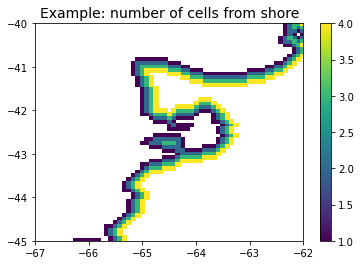

In [21]:
plt.figure()
plt.pcolormesh(X,Y, c1, shading='auto', vmin=1, vmax=4)
plt.pcolormesh(X,Y, c2+1, shading='auto', vmin=1, vmax=4)
plt.pcolormesh(X,Y, c3+2, shading='auto', vmin=1, vmax=4)
plt.pcolormesh(X,Y, c4+3, shading='auto',vmin=1, vmax=4)
plt.xlim(-67, -62)
plt.ylim(-45,-40)
plt.title('Example: number of cells from shore', fontsize=14)
plt.colorbar()

The same but wrapped around a function and a while loop.

In [22]:
def distance_to_shore(landmask, dx=1):
    """Function that computes the distance to the shore. It is based in the
    the `get_coastal_cells` algorithm.

    - landmask: the land mask built using `make_landmask` function.
    - dx: the grid cell dimesion. This is a crude approximation of the real
    distance (be careful).

    Output: 2D array containing the distances from shore.
    """
    ci = get_coastal_cells(landmask)
    landmask_i = landmask + ci
    dist = ci
    i = 0

    while i < dist.max():
        ci = get_coastal_cells(landmask_i)
        landmask_i += ci
        dist += ci*(i+2)
        i += 1
        
    return dist*dx

In [23]:
dist_SA = distance_to_shore(landmask)

Text(0.5, 1.0, 'Cells from shore South Atlantic')

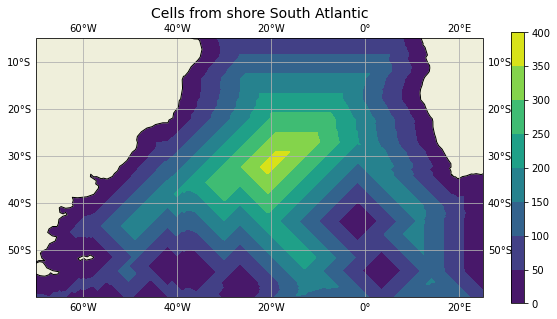

In [24]:
fig,ax = plt.subplots(figsize=(10,5),
                      subplot_kw={'projection': ccrs.LambertConformal()})

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent((-70, 25, -60, -5), crs=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND, zorder=1)
ax.add_feature(cfeature.COASTLINE)
ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False)

im = ax.contourf(X, Y, dist_SA)
plt.colorbar(im)
ax.set_title('Cells from shore South Atlantic', fontsize=14)

> obs: it assumes that the upper limit is a coast. To avoid that use the global landmask.

**To implement later:** a way to compute the errors or confidence interval. 

In [25]:
def haversine_distance_two(point_A, point_B):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    
    """
    lat1, lon1 = point_A
    lat2, lon2 = point_B
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [26]:
lon_dx = haversine_distance_two((40,0),(40,1))/12
lon_dx

7.093860769979677

In [27]:
lat_dx = haversine_distance_two((40,0),(41,0))/12
lat_dx

9.26042612287326

The error associated to the distance from shore could be estimated as:

`e_max = dist*(dx - lon_dx)` and `e_min = dist*(dx - lat_dx)`.

### 6. Saving in a .nc file

In [28]:
ds = xr.Dataset(
    data_vars=dict(
        landmask=(["y", "x"], landmask),
        coastal=(["y", "x"], coastal),
        shore=(["y", "x"], shore),
        coastal_u=(["y", "x"], v_x),
        coastal_v=(["y", "x"], v_y),
        distance2shore=(["y", "x"], dist_SA),
        latitude=(["y", "x"], Y),
        longitude=(["y", "x"], X),),
    
    coords=dict(lon=(["x"], lons.values),
        lat=(["y"], lats.values),),
    
    attrs=dict(description="setup files for simulation",
               index_lat=(indices['lat'].start, indices['lat'].stop),
              index_lon=(indices['lon'].start, indices['lon'].stop)),)

#ds.to_netcdf("output_path")

In [29]:
ds

<xarray.Dataset>
Dimensions:         (x: 1176, y: 959)
Coordinates:
    lon             (x) float32 -73.0 -72.92 -72.83 -72.75 ... 24.75 24.83 24.92
    lat             (y) float32 -79.92 -79.83 -79.75 ... -0.25 -0.1667 -0.08333
Dimensions without coordinates: x, y
Data variables:
    landmask        (y, x) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
    coastal         (y, x) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    shore           (y, x) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    coastal_u       (y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    coastal_v       (y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    distance2shore  (y, x) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    latitude        (y, x) float32 -79.92 -79.92 -79.92 ... -0.08333 -0.08333
    longitude       (y, x) float32 -73.0 -72.92 -72.83 ... 24.75 24.83 24.92
Attributes:
    description:  setup files for simulation
    index_lat:    (1, 960)
    index_lon:    (1284, 2460)

### Extra. Point Nemo

Just a small example to see how accurate it's the algorithm. Let's see if the most distant region in the South Pacific matches with [Point Nemo](https://oceanservice.noaa.gov/facts/nemo.html).

In [30]:
indices_south_pacific = {'lat': range(1, 900), 'lon': range(0, 1284)}
lat_sp = model.variables['latitude'][indices_south_pacific['lat']].data
lon_sp = model.variables['longitude'][indices_south_pacific['lon']].data
x_sp, y_sp = np.meshgrid(lon_sp, lat_sp)

In [31]:
landmask_sp = make_landmask(file_path, indices_south_pacific)

In [32]:
dist_sp = distance_to_shore(landmask_sp)

In [33]:
point_nemo = (-48.89, -123.45)

Text(0.5, 1.0, 'Cells from shore in the South Pacific')

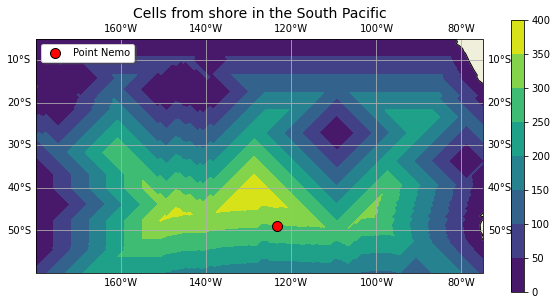

In [34]:
fig,ax = plt.subplots(figsize=(10,5),
                      subplot_kw={'projection': ccrs.PlateCarree()})

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent((-180, -75, -60, -5), crs=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND, zorder=1)
ax.add_feature(cfeature.COASTLINE)
ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False)

im = ax.contourf(x_sp, y_sp, dist_sp)

ax.scatter(point_nemo[1], point_nemo[0], 
           s=100, marker='o', color='red', 
           edgecolors='k', zorder=3, label = 'Point Nemo')


plt.legend(shadow=True, loc='upper left')
plt.colorbar(im)
ax.set_title('Cells from shore in the South Pacific', fontsize=14)

> It doesn't match but fair enough...